In [58]:
from IPython.core.display import HTML, display
import pickle
from warnings import filterwarnings

import pymc3 as pm
import theano.tensor as tt
from theano import shared

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from seaborn import heatmap
import matplotlib.pyplot as pl
from matplotlib import rcParams
from cmocean import cm as cmo

from pymc_utils import PyMCModel
from pymc_utils import subset_significant_feature
from pymc_utils import plot_fits_with_unc

ImportError: cannot import name 'plot_fits_with_unc'

In [4]:
filterwarnings('ignore', category=UserWarning)

In [5]:
display(HTML("<style>.container {width: 90% !important}</style>"))

In [6]:
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16

In [59]:
# Plot Fits with Uncertainty Estimates
def plot_fits_with_unc(y_obs, ppc_, ax=None):
    iy  = np.argsort(y_obs)
    ix = np.arange(iy.size)
    lik_mean =ppc_.mean(axis=0)
    lik_hpd = pm.hpd(ppc_)
    lik_hpd_05 = pm.hpd(ppc_, alpha=0.5)
    if ax is None:
        _, ax = pl.subplots(figsize=(12, 8))
        ax.scatter(ix, y_obs.values[iy], label='observed', edgecolor='k', s=50,
                   color='steelblue');
        ax.scatter(ix, lik_mean[iy], label='modeled', edgecolor='k', s=50, color='m')

        ax.fill_between(ix, y1=lik_hpd_05[iy, 0], y2=lik_hpd_05[iy, 1], alpha=0.5, color='k',
                       label='model output 50%CI');
        ax.fill_between(ix, y1=lik_hpd[iy, 0], y2=lik_hpd[iy, 1], alpha=0.5, color='k',
                       label='model output 95%CI');
        ax.legend(loc='upper left');
    return ax

In [19]:
def bayes_nn_l2_h(X, y_obs, n_hidden, lklhd_name='likelihood', include_bias=False,
                 #parameterize_elu=False
                 ):
    """
    Hierarchical Bayesian NN Implementation.
    
    Inputs:
    --------
    X: theano shared variable,
    y_obs: numpy vector,
    n_hidden: tuple, unit number for each HL,
    lklhd_name: name of the likelihood variable.
    
    Output:
    --------
    PyMC3 model
    """
    X = pm.floatX(X)
    Y = pm.floatX(y_obs)
    n_hidden1, n_hidden2 = n_hidden
    if hasattr(X, 'name'):
        num_obs, num_feats = X.eval().shape
    else:
        num_obs, num_feats = X.shape
    """elu_init_scale1 = np.sqrt(2) * np.sqrt(2 / (num_feats + n_hidden1))
    elu_init_scale2 = np.sqrt(2) * np.sqrt(2 / (n_hidden1 + n_hidden2))"""
    with pm.Model() as model:
        """
        if parameterize_elu:
            alpha_elu = pm.HalfNormal('alpha_elu', sd=1, shape=(2,))
        else:
            alpha_elu = [1, 1]"""
        hyper_b1_sd = pm.HalfCauchy('hyper_b1_sd', beta=1)
        hyper_b2_sd = pm.HalfCauchy('hyper_b2_sd', beta=1)
        hyper_w1_sd = pm.HalfCauchy('hyper_w1_sd', beta=1, shape=(num_feats, 1))
        hyper_w2_sd = pm.HalfCauchy('hyper_w2_sd', beta=1, shape=(n_hidden1, 1))
        hyper_w3_sd = pm.HalfCauchy('hyper_w3_sd', beta=1)
        init_1 = np.random.randn(num_feats, n_hidden1)# * elu_init_scale1
        init_2 = np.random.randn(n_hidden1, n_hidden2)# * elu_init_scale2
        init_3 = np.random.randn(n_hidden2,)
        if include_bias:   
            init_b1 = np.random.randn(n_hidden1,)
            init_b2 = np.random.randn(n_hidden2,)
            init_b3 = np.random.randn()
            b1 = pm.Normal('bias_layer1', mu=0, sd=hyper_b1_sd, shape=(n_hidden1,),
                           testval=init_b1)
            b2 = pm.Normal('bias_layer2', mu=0, sd=hyper_b2_sd, shape=(n_hidden2,),
                          testval=init_b2)
            b3 = pm.Normal('bias_layer3', mu=0, sd=1, testval=init_b3)
        else:
            b1 = b2 = b3 = 0
        w1 = pm.Normal('wts_i_1', mu=0, sd=hyper_w1_sd, shape=(num_feats, n_hidden1), 
                      testval=init_1)
        w2 = pm.Normal('wts_1_2', mu=0, sd=hyper_w2_sd, shape=(n_hidden1, n_hidden2),
                      testval=init_2)
        w3 = pm.Normal('wts_2_out', mu=0, sd=hyper_w3_sd, shape=(n_hidden2,),
                      testval=init_3)
        lyr1_act = pm.Deterministic('layer1_act', tt.nnet.relu(tt.dot(X, w1),
                                                              # alpha=alpha_elu[0]
                                                              ) + b1)
        lyr2_act = pm.Deterministic('layer2_act', tt.nnet.relu(tt.dot(lyr1_act, w2),
                                                              # alpha=alpha_elu[1]
                                                              ) + b2)
        out_act = pm.Deterministic('layer3_act', tt.dot(lyr2_act, w3) + b3)
        
        sd = pm.HalfCauchy('sd', beta=2.5)
        output = pm.Normal(lklhd_name, mu=out_act, sd=sd, observed=Y)
    return model

In [6]:
def bayes_nn_l3_h(X, y_obs, n_hidden1, n_hidden2, n_hidden3, lklhd_name='likelihood', include_bias=False):
    """
    Hierarchical Bayesian NN Implementation.
    
    Inputs:
    --------
    X: theano shared variable,
    y_obs: numpy vector,
    n_hidden: number of hidden layer neurons,
    lklhd_name: name of the likelihood variable.
    
    Output:
    --------
    PyMC3 model
    """
    X = pm.floatX(X)
    Y = pm.floatX(y_obs)
    if hasattr(X, 'name'):
        num_obs, num_feats = X.eval().shape
    else:
        num_obs, num_feats = X.shape
    elu_init_scale1 = np.sqrt(2) * np.sqrt(2 / (num_feats + n_hidden1))
    elu_init_scale2 = np.sqrt(2) * np.sqrt(2 / (n_hidden1 + n_hidden2))
    elu_init_scale3 = np.sqrt(2) * np.sqrt(2 / (n_hidden2 + n_hidden3))
    elu_init_scale4 = np.sqrt(2) * np.sqrt(2 / (n_hidden3 + 1))
    with pm.Model() as model:
        
        init_1 = np.random.randn(num_feats, n_hidden1) * elu_init_scale1
        init_2 = np.random.randn(n_hidden1, n_hidden2) * elu_init_scale2
        init_3 = np.random.randn(n_hidden2, n_hidden3) * elu_init_scale3
        init_4 = np.random.randn(n_hidden3,) * elu_init_scale4
        if include_bias:   
            init_b1 = np.random.randn(n_hidden1,)
            init_b2 = np.random.randn(n_hidden2,)
            init_b3 = np.random.randn(n_hidden3,)
            init_b4 = np.random.randn()
            b1 = pm.Normal('bias_layer1', mu=0, sd=1, shape=(n_hidden1,),
                           testval=init_b1)
            b2 = pm.Normal('bias_layer2', mu=0, sd=1, shape=(n_hidden2,),
                          testval=init_b2)
            b3 = pm.Normal('bias_layer3', mu=0, sd=1, shape=(n_hidden3,),
                           testval=init_b3)
            b4 = pm.Normal('bias_layer4', mu=0, sd=1, testval=init_b4)
            
        else:
            b1 = b2 = b3 = b4 = 0
        hyper_w1_sd = pm.HalfCauchy('hyper_w1_sd', beta=1)
        hyper_w2_sd = pm.HalfCauchy('hyper_w2_sd', beta=1)
        hyper_w3_sd = pm.HalfCauchy('hyper_w3_sd', beta=1)
        hyper_w4_sd = pm.HalfCauchy('hyper_w4_sd', beta=1)
        w1 = pm.Normal('wts_i_1', mu=0, sd=hyper_w1_sd, shape=(num_feats, n_hidden1), 
                      testval=init_1)
        w2 = pm.Normal('wts_1_2', mu=0, sd=hyper_w2_sd, shape=(n_hidden1, n_hidden2),
                      testval=init_2)
        w3 = pm.Normal('wts_2_3', mu=0, sd=hyper_w3_sd, shape=(n_hidden2, n_hidden3),
                      testval=init_3)
        w4 = pm.Normal('wts_3_out', mu=0, sd=hyper_w4_sd, shape=(n_hidden3,))
        lyr1_act = pm.Deterministic('layer1_act', tt.nnet.elu(tt.dot(X, w1)) + b1)
        lyr2_act = pm.Deterministic('layer2_act', tt.nnet.elu(tt.dot(lyr1_act, w2)) + b2)
        lyr3_act = pm.Deterministic('layer3_act', tt.nnet.elu(tt.dot(lyr2_act, w3)) + b3)
        out_act = pm.Deterministic('out_act', tt.dot(lyr3_act, w4) + b4)
        
        sd = pm.HalfCauchy('sd', beta=2.5)
        output = pm.Normal(lklhd_name, mu=out_act, sd=sd, observed=Y)
    return model

In [8]:
band = 411
ds = pd.read_pickle('./pickleJar/OperationalDataSets/df_6_APHY_Standardized_SWF.pkl')
#ds['log10_aphy%d' % band] = np.log10(ds.loc[:, 'aphy%d' % band])
#ds.to_pickle('./pickleJar/OperationalDataSets/df_6_APHY_Standardized_SWF.pkl')

In [9]:
ds.describe().T

,count,mean,std,min,25%,50%,75%,max
sin_doy_s,162.0,-7.538551e-17,1.003101,-1.632361,-1.075398,0.291772,0.919767,1.067988
cos_doy_s,162.0,3.807825e-17,1.003101,-1.729100,-0.778317,0.208898,0.685304,1.430161
sin_minofday_s,162.0,1.915477e-16,1.003101,-0.599067,-0.553291,-0.397313,0.053463,4.165531
cos_minofday_s,162.0,-2.193033e-17,1.003101,-1.835295,-0.763772,0.101973,0.788677,2.063419
x_s,162.0,-1.045117e-16,1.003101,-2.523305,0.067800,0.101626,0.322978,2.480050
y_s,162.0,-6.030841e-17,1.003101,-0.570194,-0.540412,-0.281825,-0.081228,4.415726
z_s,162.0,-1.096945e-16,1.003101,-4.151014,0.121210,0.153920,0.480512,1.370943
log10_etopo2_s,162.0,-1.398059e-16,1.003101,-1.962412,-0.768789,-0.369002,0.760279,1.745110
oisst_s,162.0,2.193033e-17,1.003101,-2.990826,-0.781122,0.070849,0.976256,1.396973
solz_s,162.0,-1.072530e-16,1.003101,-1.851402,-0.753258,0.127265,0.760037,1.757741


In [10]:
feat_beg = 'sin_doy_s'
feat_end_ni = 'PC6_s'

X_s = ds.dropna().loc[:, :feat_end_ni]
lbls_X_s = X_s.columns.tolist()
y = ds.dropna().loc[:, 'log10_aphy%d' % band]

In [11]:
X_s_train, X_s_test, y_train, y_test = train_test_split(X_s, y, test_size=0.1,
                                                       random_state=42)
Xy_train = pd.concat((X_s_train, y_train), axis=1)

In [12]:
def plot_pairwise_corr(df_, ax=None):
    if ax is None:
        _, ax = pl.subplots(figsize=(12, 10))
    heatmap(df_.corr().iloc[1:,:-1],vmin=-1, vmax=1,
            mask=np.triu(np.ones([df_.shape[1]-1] * 2),k=1),
            ax=ax, annot=True, annot_kws={'fontsize': 10})
    ax.set_facecolor('k')
    return ax

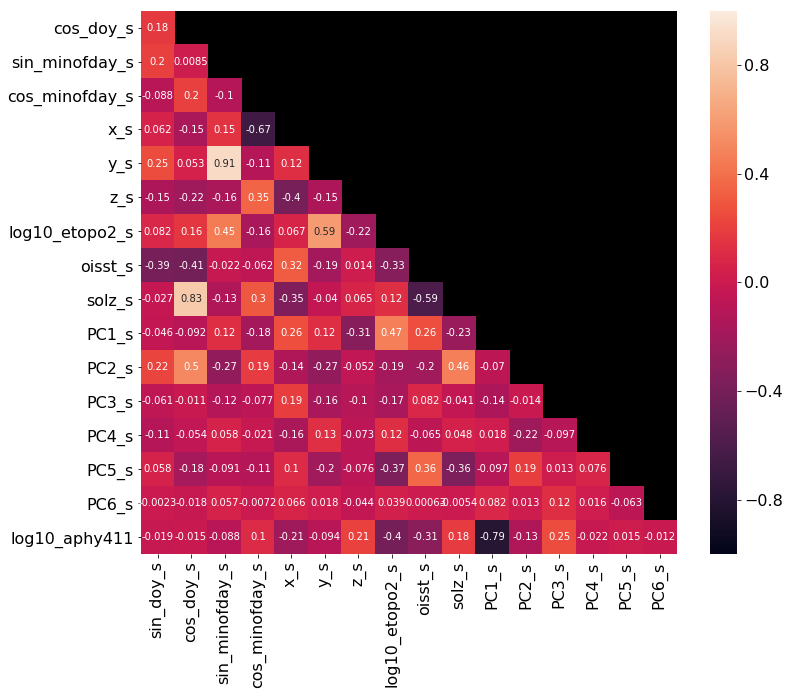

In [13]:
f, ax = pl.subplots(figsize=(12, 10))
plot_pairwise_corr(pd.concat((X_s, y), axis=1), ax=ax);

In [13]:
subset_feats = ['oisst_s', 'PC1_s', 'PC2_s', 'PC3_s', 'PC4_s', 'PC5_s', 'PC6_s']
X_s_subset = ds.dropna().loc[:, subset_feats]
X_s_sub_train, X_s_sub_test, ysub_train, ysub_test = train_test_split(X_s_subset, y,
                                                                     test_size=0.1,
                                                                     random_state=42)

### Fitting w/ All Features

####  <u>Model 1: 2-Hidden Layer BNN -- 4 units/HL</u>

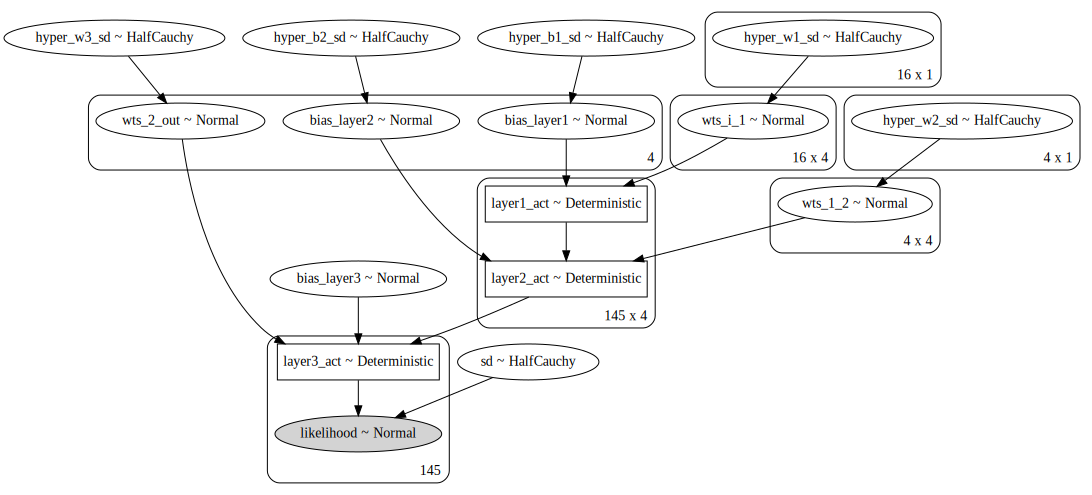

In [63]:
X_shared = shared(X_s_train.values)
bnn_l2 = PyMCModel(bayes_nn_l2_h, X_shared, y_train, n_hidden=(4, 4), include_bias=True)
bnn_l2.show_model()

In [64]:
bnn_l2.fit_ADVI(n_iter=60000, inference='svgd', inf_kwargs=dict(n_particles=400))

100%|██████████| 60000/60000 [53:39<00:00, 18.63it/s]


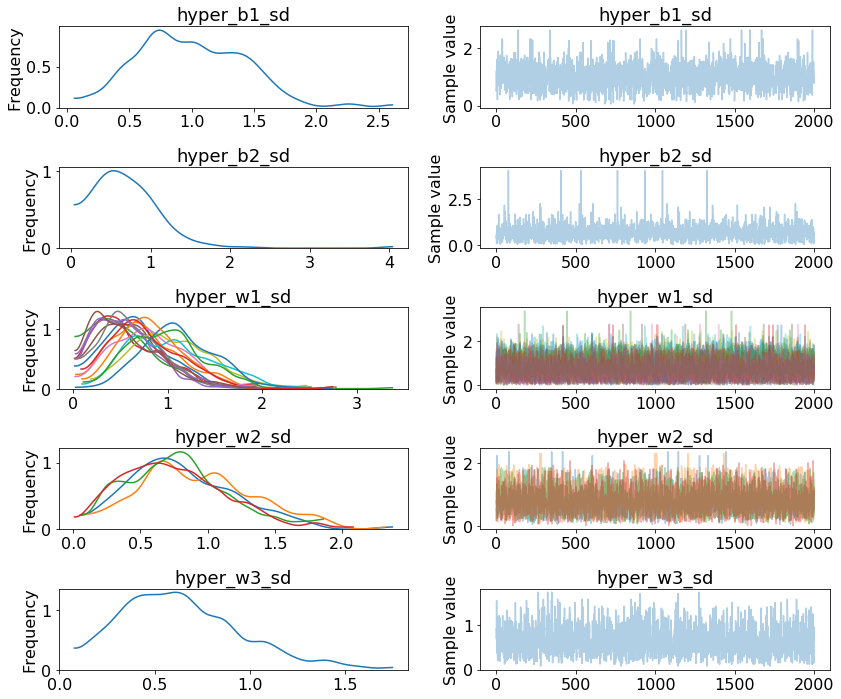

In [65]:
bnn_l2.evaluate_fit(['hyper_b1_sd', 'hyper_b2_sd', 'hyper_w1_sd', 'hyper_w2_sd', 'hyper_w3_sd']);

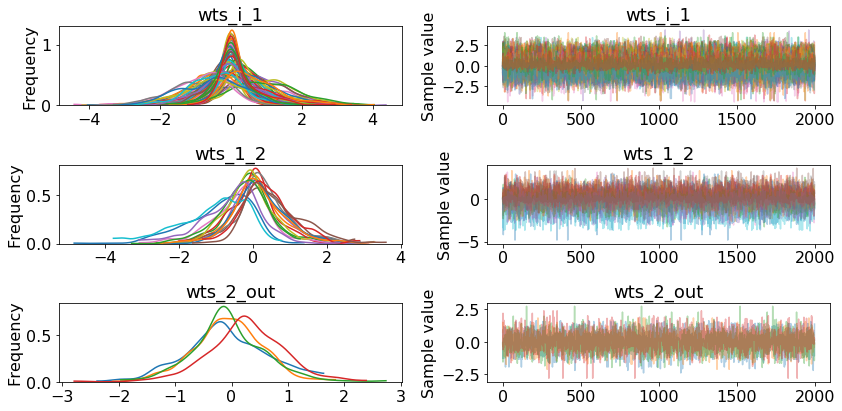

In [66]:
bnn_l2.evaluate_fit(['wts_i_1', 'wts_1_2', 'wts_2_out']);

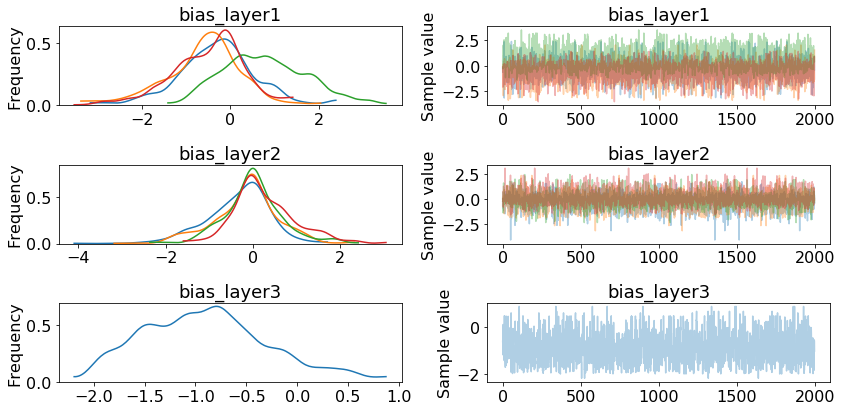

In [67]:
bnn_l2.evaluate_fit(['bias_layer1','bias_layer2', 'bias_layer3']);

100%|██████████| 2000/2000 [00:01<00:00, 1176.83it/s]


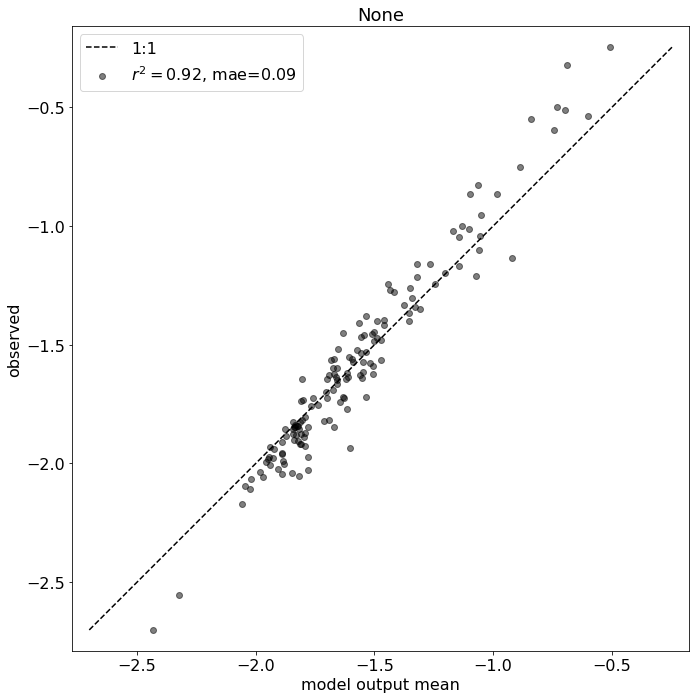

In [68]:
# Check fit on training model
ppc_train_l2 = bnn_l2.predict(likelihood_name='likelihood')
bnn_l2.plot_model_fits(y_train, ppc_train_l2, loss_metric='mae', );

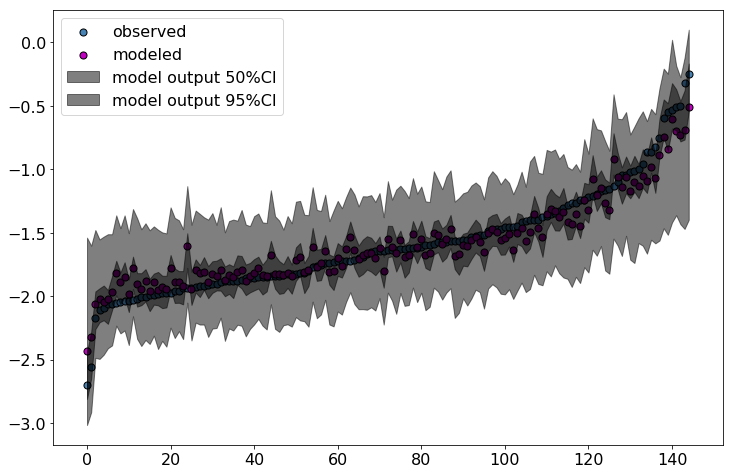

In [69]:
ax = plot_fits_with_unc(y_train, ppc_train_l2)

100%|██████████| 2000/2000 [00:02<00:00, 905.90it/s]


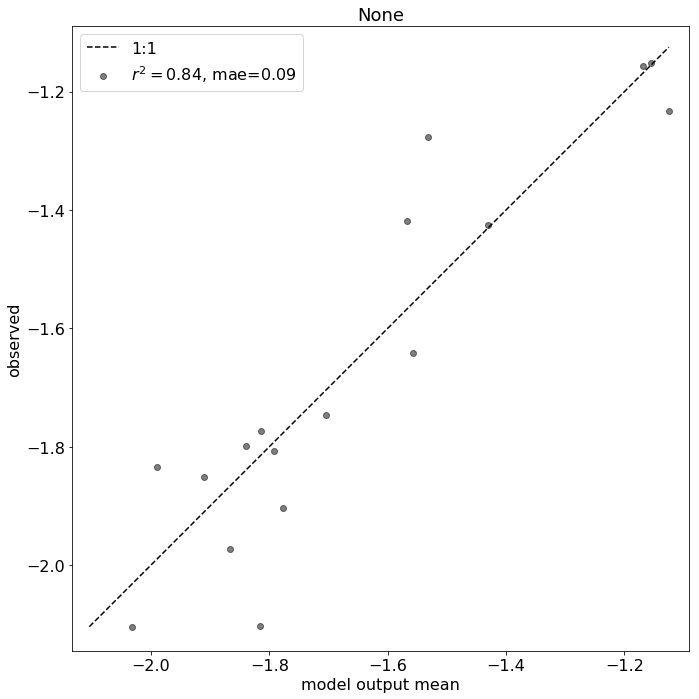

In [70]:
# Check Fit on Test Data
X_shared.set_value(X_s_test.values)
ppc_test_l2 = bnn_l2.predict(likelihood_name='likelihood')
bnn_l2.plot_model_fits(y_test, ppc_test_l2, loss_metric='mae',);

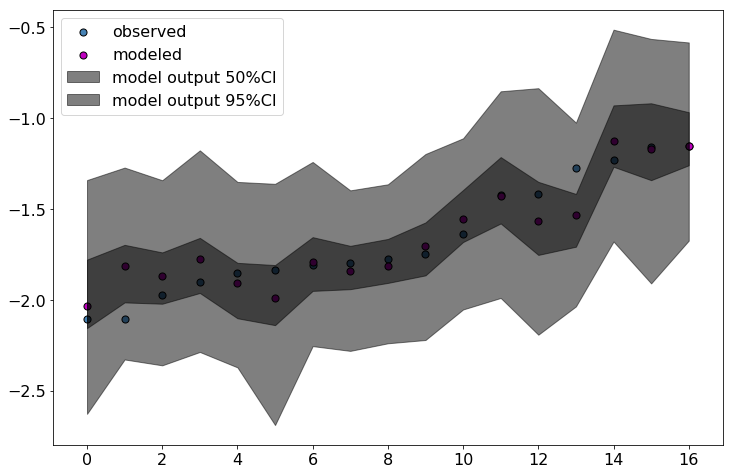

In [71]:
ax = plot_fits_with_unc(y_test, ppc_test_l2)

####  <u>Model 2: Single Layer BNN -- 8-8 units HL</u>

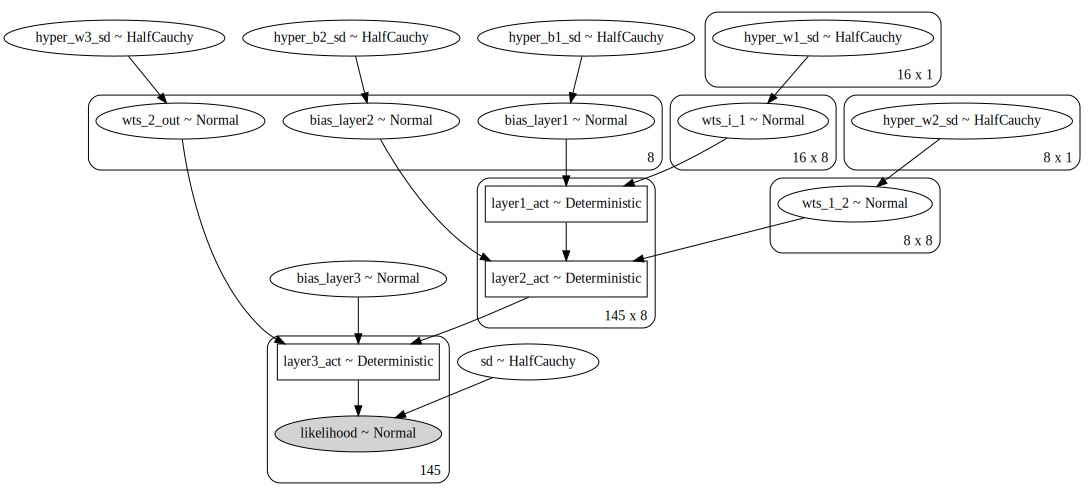

In [85]:
X_shared = shared(X_s_train.values)
bnn_l2_8_8HL = PyMCModel(bayes_nn_l2_h, X_shared, y_train, n_hidden=(8,8), include_bias=True)
bnn_l2_8_8HL.show_model()

In [ ]:
bnn_l2_8_8HL.fit_ADVI(n_iter=100000, inference='svgd', inf_kwargs=dict(n_particles=500))

 91%|█████████ | 90848/100000 [2:01:55<12:16, 12.42it/s]  

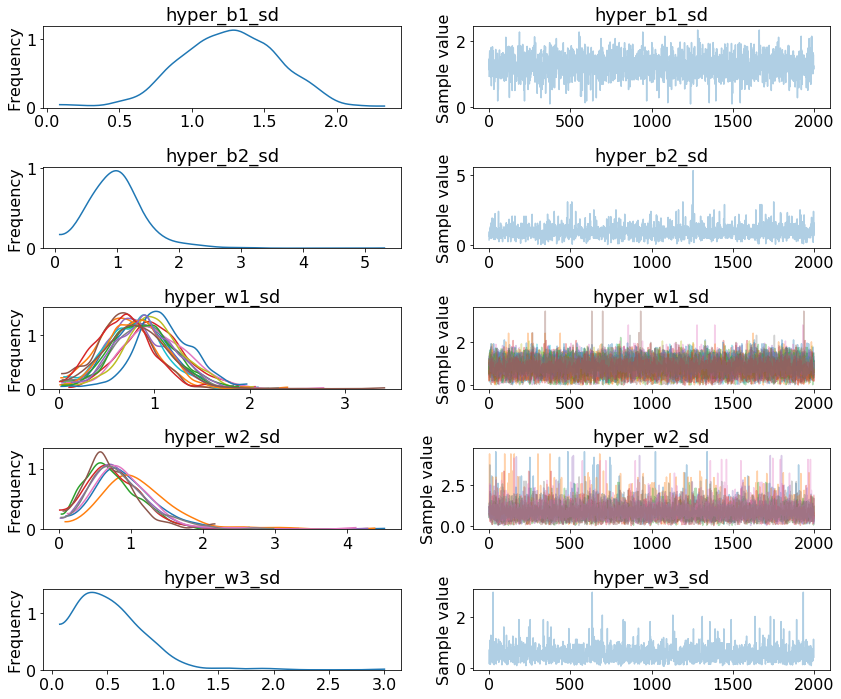

In [77]:
bnn_l2_8_4HL.evaluate_fit(['hyper_b1_sd', 'hyper_b2_sd', 'hyper_w1_sd', 'hyper_w2_sd', 'hyper_w3_sd']);

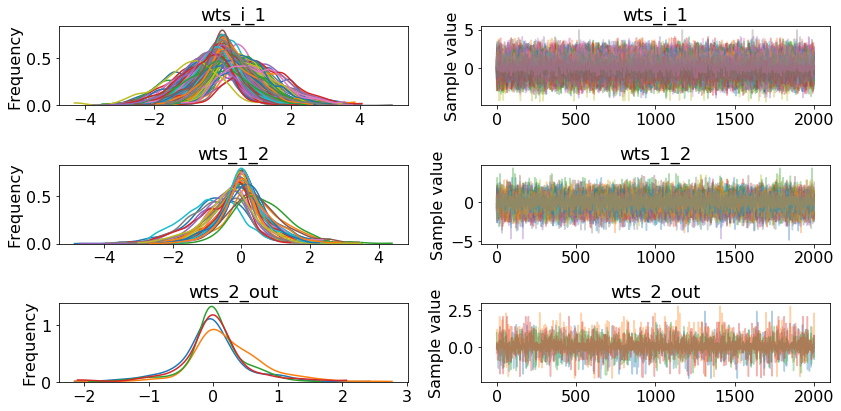

In [78]:
bnn_l2_8_4HL.evaluate_fit(['wts_i_1', 'wts_1_2', 'wts_2_out']);

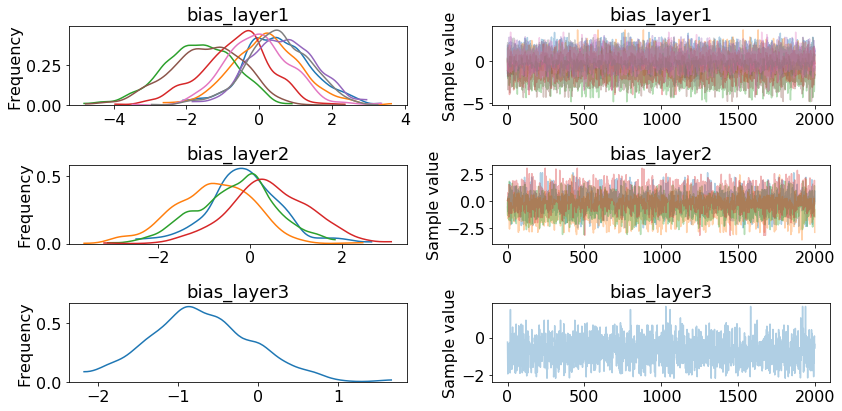

In [79]:
bnn_l2_8_4HL.evaluate_fit(['bias_layer1','bias_layer2', 'bias_layer3']);

100%|██████████| 2000/2000 [00:01<00:00, 1194.52it/s]


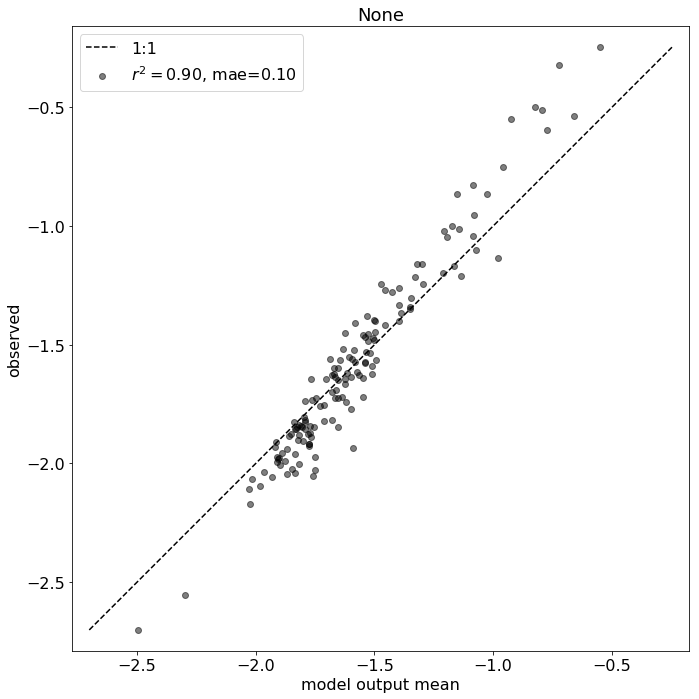

In [80]:
# Check fit on training model
ppc_train_l2_8_4HL = bnn_l2_8_4HL.predict(likelihood_name='likelihood')
bnn_l2_8_4HL.plot_model_fits(y_train, ppc_train_l2_8_4HL, loss_metric='mae', );

100%|██████████| 2000/2000 [00:02<00:00, 947.58it/s]


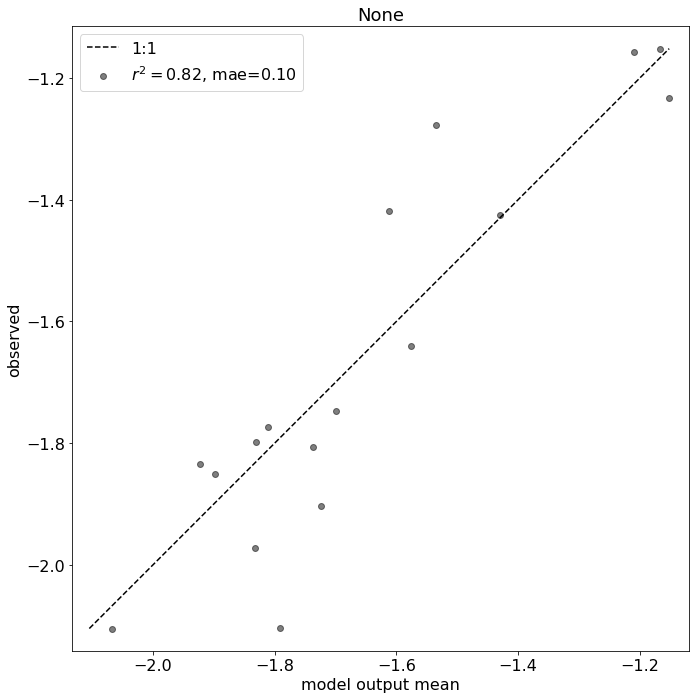

In [81]:
# Check Fit on Test Data
X_shared.set_value(X_s_test.values)
ppc_test_l2_8_4HL = bnn_l2_8_4HL.predict(likelihood_name='likelihood')
bnn_l2_8_4HL.plot_model_fits(y_test, ppc_test_l2_8_4HL, loss_metric='mae',);

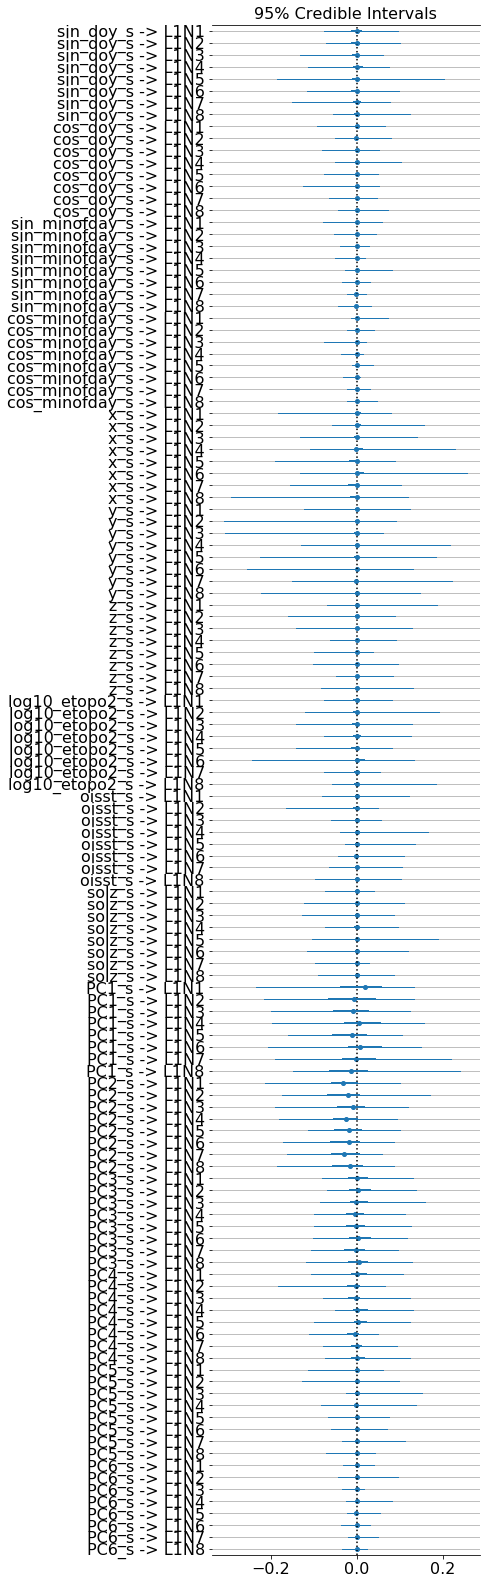

In [50]:
labels = ['%s -> L1N%d' %(li, ni) for li in lbls_X_s for ni in range(1, 9)]
bnn_l1_8HL.show_forest(['wts_i_1'], feat_labels=labels)
f = pl.gcf()
f.set_figheight(25);

100%|██████████| 2000/2000 [00:01<00:00, 1405.21it/s]


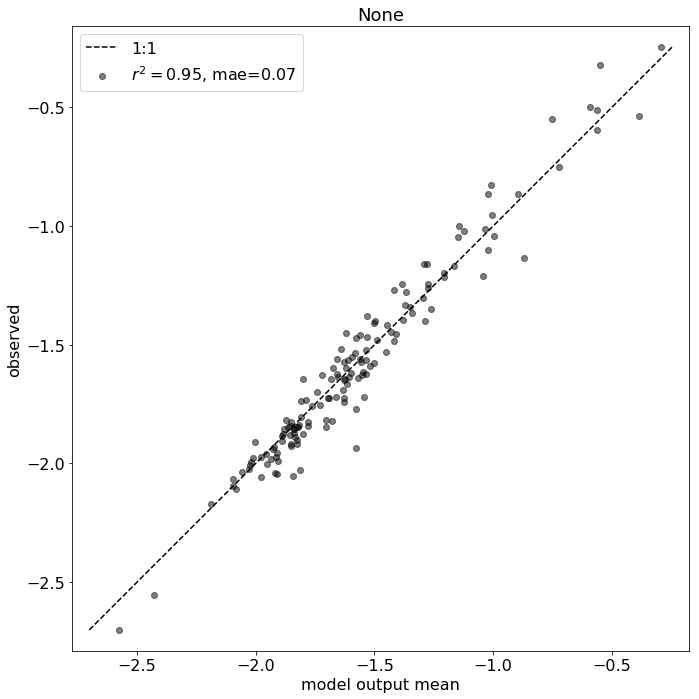

In [51]:
# Check fit on training model
ppc_train_l1_8HL = bnn_l1_8HL.predict(likelihood_name='likelihood')
bnn_l1_8HL.plot_model_fits(y_train, ppc_train_l1_8HL, loss_metric='mae', );

100%|██████████| 2000/2000 [00:01<00:00, 1113.06it/s]


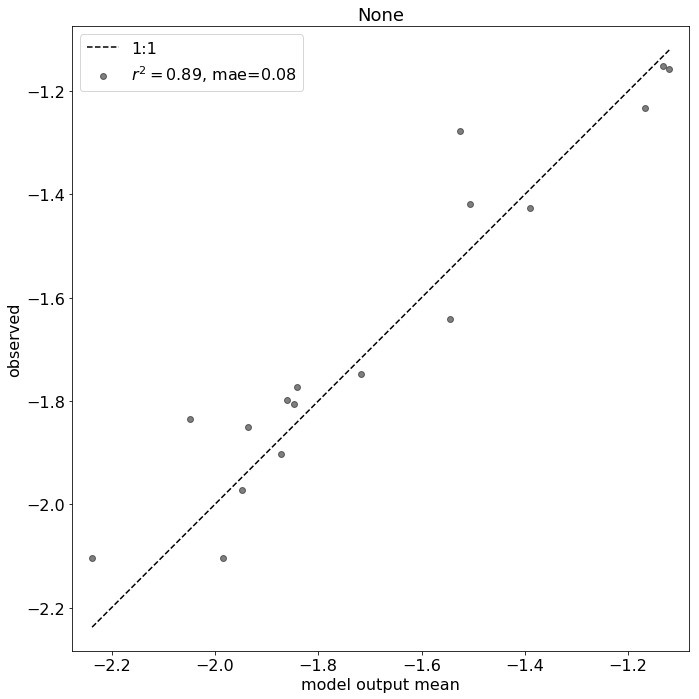

In [52]:
# Check Fit on Test Data
X_shared.set_value(X_s_test.values)
ppc_test_l1_8HL = bnn_l1_8HL.predict(likelihood_name='likelihood')
bnn_l1_8HL.plot_model_fits(y_test, ppc_test_l1_8HL, loss_metric='mae',);

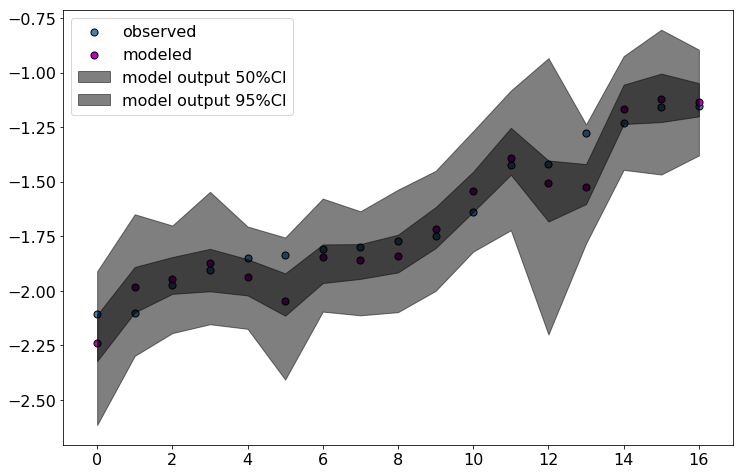

In [53]:
# Plot Fits with Uncertainty Estimates
iy  = np.argsort(y_test)
ix = np.arange(iy.size)
ppc_test = ppc_test_l1_8HL
lik_mean =ppc_test.mean(axis=0)
lik_hpd = pm.hpd(ppc_test)
lik_hpd_05 = pm.hpd(ppc_test, alpha=0.5)

f_fit2, ax = pl.subplots(figsize=(12, 8))
ax.scatter(ix, y_test.values[iy], label='observed', edgecolor='k', s=50,
           color='steelblue');
ax.scatter(ix, lik_mean[iy], label='modeled', edgecolor='k', s=50, color='m')

ax.fill_between(ix, y1=lik_hpd_05[iy, 0], y2=lik_hpd_05[iy, 1], alpha=0.5, color='k',
               label='model output 50%CI');
ax.fill_between(ix, y1=lik_hpd[iy, 0], y2=lik_hpd[iy, 1], alpha=0.5, color='k',
               label='model output 95%CI');
ax.legend(loc='upper left');
#f_fit2.savefig('./figJar/bayesNet/bNN_L1_nobias.png', dpi=300, format='png')

<u>Re-Train Model with Entire Data Set for Inter-Model Comparison</u>

In [86]:
pickledModelDict = {bnn_l1.model.name: bnn_l1,
                   bnn_l1_pc.model.name: bnn_l1_pc,
                   bnn_l1_sub.model.name: bnn_l1_sub}
with open('./pickleJar/Models/Aphi%d_BNN_ARD.pkl' % band, 'wb') as f:
    pickle.dump(pickledModelDict, f, protocol=pickle.HIGHEST_PROTOCOL)